# Finding suspicious behavior by tracking down outliers

To reproduce this finding from the Dallas Morning News, we'll need to use standard deviation, regression, and residuals to identify schools that performed suspiciously well in certain standardized tests.

<p class="reading-options">
  <a class="btn" href="/dmn-texas-school-cheating/texas-school-cheating-finding-outliers-with-regression-residuals">
    <i class="fa fa-sm fa-book"></i>
    Read online
  </a>
  <a class="btn" href="/dmn-texas-school-cheating/notebooks/Texas School Cheating - Finding outliers with regression residuals.ipynb">
    <i class="fa fa-sm fa-download"></i>
    Download notebook
  </a>
  <a class="btn" href="#">
    <i class="fa fa-sm fa-laptop"></i>
    Interactive version
  </a>
</p>

### Prep work: Downloading necessary files
Before we get started, we need to download all of the data we'll be using.
* **cfy04e4.dat:** 2004 fourth-grade TAKS scores - standardized test scores for 2004's fourth-graders
* **cfy03e3.dat:** 2003 third-grade TAKS scores - standardized test scores for 2003's third-graders
* **cfy04e5.dat:** 2004 fifth-grade TAKS scores - standardized test scores for 2004's fifth-graders
* **cfy04e3.dat:** 2004 third-grade TAKS scores - standardized test scores for 2004's third-graders


In [ ]:
# Make data directory if it doesn't exist
!mkdir -p data
!wget -nc https://nyc3.digitaloceanspaces.com/ml-files-distro/v1/dmn-texas-school-cheating/data/cfy04e4.dat -P data
!wget -nc https://nyc3.digitaloceanspaces.com/ml-files-distro/v1/dmn-texas-school-cheating/data/cfy03e3.dat -P data
!wget -nc https://nyc3.digitaloceanspaces.com/ml-files-distro/v1/dmn-texas-school-cheating/data/cfy04e5.dat -P data
!wget -nc https://nyc3.digitaloceanspaces.com/ml-files-distro/v1/dmn-texas-school-cheating/data/cfy04e3.dat -P data

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

pd.set_option("display.max_rows", 200)
pd.set_option("display.max_columns", 200)

# Reading in our data

We'll start by opening up our dataset - standardized test performance at each school, for fourth graders in 2004 and third graders in 2003.

In [23]:
df = pd.read_csv("data/cfy04e4.dat", usecols=['r_all_rs', 'CNAME', 'CAMPUS'])
df = df.set_index('CAMPUS').add_suffix('_fourth')
df.head(3)

,CNAME_fourth,r_all_rs_fourth
CAMPUS,,
1902103,CAYUGA EL,2392.0
1903101,ELKHART EL,2263.0
1904102,FRANKSTON EL,2242.0


In [24]:
third_graders = pd.read_csv("data/cfy03e3.dat", usecols=['CAMPUS', 'r_all_rs'])
third_graders = third_graders.set_index('CAMPUS').add_suffix('_third')
merged = df.join(third_graders)
merged.head(3)

,CNAME_fourth,r_all_rs_fourth,r_all_rs_third
CAMPUS,,,
1902103,CAYUGA EL,2392.0,2330.0
1903101,ELKHART EL,2263.0,2285.0
1904102,FRANKSTON EL,2242.0,2299.0


# Using a regression to predict fourth-grade scores

The Dallas Morning News decided to run a **regression**, which is a way of predicting how two different variables interact. In this case, we want to see the relationship between a **third grade score** and a **fourth grade score**.

First we'll need to get rid of missing data, because regressions hate hate hate missing data.

In [25]:
print("Before dropping missing data", merged.shape)
merged = merged.dropna()
print("After dropping missing data", merged.shape)

Before dropping missing data (3780, 3)
After dropping missing data (3501, 3)


And now we can ask what the relationship is between third-grade scores and fourth-grade scores.

In [26]:
import statsmodels.formula.api as smf

model = smf.ols("r_all_rs_fourth ~ r_all_rs_third", data=merged)

results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        r_all_rs_fourth   R-squared:                       0.647
Model:                            OLS   Adj. R-squared:                  0.647
Method:                 Least Squares   F-statistic:                     6410.
Date:                Tue, 05 Nov 2019   Prob (F-statistic):               0.00
Time:                        08:31:22   Log-Likelihood:                -17961.
No. Observations:                3501   AIC:                         3.593e+04
Df Residuals:                    3499   BIC:                         3.594e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept        632.6929     19.936     31.736      0.000     593.606     671.780
r_all_rs_third     0.7094      0.009     80.061      0.000       0.692       0.727
==============================================================================
Omnibus:                      263.054   Durbin-Watson:                   1.897
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1312.900
Skew:                           0.147   Prob(JB):                    8.08e-286
Kurtosis:                       5.986   Cond. No.                     6.49e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.49e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

What's this all mean? It doesn't matter! What matters is that **if we know what third-grade score a school got, we can try to predict its fourth-grade score.**

In [27]:
merged['predicted_fourth'] = results.predict()
merged.head()

,CNAME_fourth,r_all_rs_fourth,r_all_rs_third,predicted_fourth
CAMPUS,,,,
1902103,CAYUGA EL,2392.0,2330.0,2285.616126
1903101,ELKHART EL,2263.0,2285.0,2253.692715
1904102,FRANKSTON EL,2242.0,2299.0,2263.624443
1906102,NECHES EL,2218.0,2236.0,2218.931668
1907110,STORY EL,2200.0,2202.0,2194.811757


## Using standard deviations with regression error

Notice how there's a difference between the _actual_ fourth-grade score and the _predicted_ fourth-grade score. This is called the **error** or **residual**. The bigger the error, the bigger the difference between what was expected and what actually happened.

Remember how we were suspicious of that one school because it performed normally, but then performed really well? A school like that is going to have a really big error!

To calculate what a suspiciously large error is, we're going to use our old friend **standard deviation.** Before we used standard deviation to see how far a school's score was from the average score. This time we're going to use standard deviation to see how far the school's error is from the average error!

In [28]:
# Just trust me, this is how you do it
merged['error_std_dev'] = results.resid / np.sqrt(results.mse_resid)
merged.head()

,CNAME_fourth,r_all_rs_fourth,r_all_rs_third,predicted_fourth,error_std_dev
CAMPUS,,,,,
1902103,CAYUGA EL,2392.0,2330.0,2285.616126,2.600187
1903101,ELKHART EL,2263.0,2285.0,2253.692715,0.227484
1904102,FRANKSTON EL,2242.0,2299.0,2263.624443,-0.528535
1906102,NECHES EL,2218.0,2236.0,2218.931668,-0.022771
1907110,STORY EL,2200.0,2202.0,2194.811757,0.126809


The more standard deviations away from the mean a school's error is, the bigger the gap between actual and predicted scores, and **the more suspicious its fourth-grade performance is.**

In [29]:
merged.sort_values(by='error_std_dev', ascending=False).head(10)

,CNAME_fourth,r_all_rs_fourth,r_all_rs_third,predicted_fourth,error_std_dev
CAMPUS,,,,,
57905115,HARRELL BUDD EL,2470.0,2140.0,2150.828391,7.801048
123803101,TEKOA ACADEMY O,2313.0,2021.0,2066.408705,6.027073
15803101,HIGGS/CARTER/KI,2349.0,2097.0,2120.323799,5.589200
101912172,HENDERSON N EL,2324.0,2093.0,2117.486162,5.047518
180901101,MIMI FARLEY ELE,2448.0,2294.0,2260.077397,4.593119
57825001,PINNACLE SCHOOL,2274.0,2068.0,2099.750934,4.258917
131001103,SARITA EL,2509.0,2424.0,2352.300584,3.829976
101823101,CHILDREN FIRST,2252.0,2066.0,2098.332116,3.755881
61911111,PRAIRIE VIEW EL,2389.0,2261.0,2236.666896,3.723257


# Reproducing the story

From The Dallas Morning News:

> "In statistician's lingo, these schools had at least one average score that was more than three standard deviations away from what would be predicted based on their scores in other grades or on other tests

While we've been talking about schools with a **major increase** between the two years, we're also interested in schools with a **major drop**. That could indicate cheating in 2003 and a return to "real" testing in 2004.

Let's check out all of our suspicious schools according to the three standard deviations test they performed.

In [30]:
merged[merged.error_std_dev.abs() > 3]

,CNAME_fourth,r_all_rs_fourth,r_all_rs_third,predicted_fourth,error_std_dev
CAMPUS,,,,,
15803101,HIGGS/CARTER/KI,2349.0,2097.0,2120.323799,5.589200
15819001,SHEKINAH RADIAN,1976.0,2149.0,2157.213074,-4.429128
19901102,DEKALB EL,2356.0,2223.0,2209.709349,3.575570
22004101,TERLINGUA EL,2055.0,2178.0,2177.785938,-3.001078
25904101,BLANKET EL,2082.0,2225.0,2211.128167,-3.156092
47905001,SIDNEY SCHOOL,2208.0,2024.0,2068.536933,3.408693
50901101,EVANT EL,2169.0,2345.0,2296.257263,-3.110365
57817101,FOCUS LEARNING,1973.0,2079.0,2107.554435,-3.288719
57825001,PINNACLE SCHOOL,2274.0,2068.0,2099.750934,4.258917


But then they level things up a bit:

> Using a stricter standard - four standard deviations from predictions - 41 schools have suspect scores

In [31]:
merged[merged.error_std_dev.abs() > 4]

,CNAME_fourth,r_all_rs_fourth,r_all_rs_third,predicted_fourth,error_std_dev
CAMPUS,,,,,
15803101,HIGGS/CARTER/KI,2349.0,2097.0,2120.323799,5.589200
15819001,SHEKINAH RADIAN,1976.0,2149.0,2157.213074,-4.429128
57825001,PINNACLE SCHOOL,2274.0,2068.0,2099.750934,4.258917
57905115,HARRELL BUDD EL,2470.0,2140.0,2150.828391,7.801048
101840101,TWO DIMENSIONS,2076.0,2275.0,2246.598624,-4.169694
101912134,CRAWFORD EL,2056.0,2240.0,2221.769304,-4.051658
101912140,DOGAN EL,1972.0,2150.0,2157.922483,-4.544233
101912172,HENDERSON N EL,2324.0,2093.0,2117.486162,5.047518
105802041,SAN MARCOS PREP,2025.0,2245.0,2225.316350,-4.896042


Our dataset isn't as thorough as theirs - we're only looking at one combination of tests - but it's the same idea.

# Finding other suspicious scores

We might assume a school that does well in reading probably also does well in math.

**What if they did well in one, but not the other?** While the school might just have a strong department in one particular field, such discripancies could be worth investigating.

Let's look at fifth graders' math and reading scores from 2004.

In [32]:
df = pd.read_csv("data/cfy04e5.dat", usecols=['CAMPUS', 'CNAME', 'm_all_rs', 'r_all_rs'])
df = df.set_index('CAMPUS').add_suffix('_fifth')
df.head()

,CNAME_fifth,r_all_rs_fifth,m_all_rs_fifth
CAMPUS,,,
1902103,CAYUGA EL,2308.0,2317.0
1903101,ELKHART EL,2193.0,2153.0
1904102,FRANKSTON EL,2288.0,2256.0
1906102,NECHES EL,2298.0,2312.0
1907110,STORY EL,2218.0,2269.0


# Building the graphic

While it isn't necessary, reproducing the graphics is always fun.

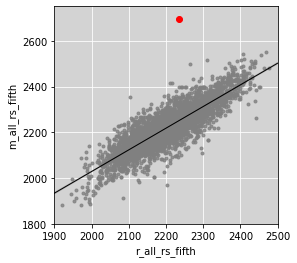

In [33]:
fig, ax = plt.subplots(figsize=(4,4))

ax.set_xlim(1900, 2500)
ax.set_ylim(1800, 2750)
ax.set_facecolor('lightgrey')
ax.grid(True, color='white')
ax.set_axisbelow(True)

sns.regplot('r_all_rs_fifth',
            'm_all_rs_fifth',
            data=df,
            marker='.', 
            line_kws={"color": "black", "linewidth": 1},
            scatter_kws={"color": "grey"})

highlight = df.loc[101912236]
plt.plot(highlight.r_all_rs_fifth, highlight.m_all_rs_fifth, 'ro')

# Running the regression

We can't be exactly sure of the relationship between math and reading scores - it's a lot of schools! - so we'll run a regression to figure out how the two scores typically interact.

In [18]:
print("Before dropping missing data", df.shape)
df = df.dropna()
print("After dropping missing data", df.shape)

Before dropping missing data (3571, 3)
After dropping missing data (3452, 3)


In [19]:
import statsmodels.formula.api as smf

model = smf.ols("m_all_rs_fifth ~ r_all_rs_fifth", data=df)

results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         m_all_rs_fifth   R-squared:                       0.735
Model:                            OLS   Adj. R-squared:                  0.735
Method:                 Least Squares   F-statistic:                     9570.
Date:                Tue, 05 Nov 2019   Prob (F-statistic):               0.00
Time:                        08:27:21   Log-Likelihood:                -18443.
No. Observations:                3452   AIC:                         3.689e+04
Df Residuals:                    3450   BIC:                         3.690e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept        136.3779     21.321      6.397      0.000      94.576     178.180
r_all_rs_fifth     0.9462      0.010     97.826      0.000       0.927       0.965
==============================================================================
Omnibus:                      210.369   Durbin-Watson:                   1.687
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              858.872
Skew:                           0.127   Prob(JB):                    3.15e-187
Kurtosis:                       5.430   Cond. No.                     5.46e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.46e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

And now, just like last time, we calculate how many standard deviations away the actual score was from the predicted score. Large number of standard deviations away means a school is worth a look!

In [21]:
df['error_std_dev'] = results.resid / np.sqrt(results.mse_resid)

df[df.error_std_dev.abs() > 3].sort_values(by='error_std_dev', ascending=False)

,CNAME_fifth,r_all_rs_fifth,m_all_rs_fifth,error_std_dev
CAMPUS,,,,
101912236,SANDERSON EL,2235.0,2696.0,8.790097
109908101,MALONE EL,2104.0,2355.0,4.501120
101912113,BOWIE EL,2265.0,2498.0,4.316536
188901130,SUNRISE EL,2311.0,2517.0,3.831884
240901120,J C MARTIN JR E,2212.0,2417.0,3.706908
40901102,MORTON EL,2215.0,2417.0,3.650814
72909001,LINGLEVILLE SCH,2148.0,2017.0,-3.000714
233903001,COMSTOCK SCHOOL,2241.0,2100.0,-3.099482
178904152,BARNES EL,2233.0,2092.0,-3.107985


Wow, look at that! Sanderson Elementary looks like they either have a **really** exceptional math program or something suspicious is going on.

# Review

First, we learned about using **standard deviation** as a measurement of how unusual a measurement in a data point might be. Data points that fall many standard deviations from the mean - either above or below - might be worth investigating as bad data or from other suspicious angles (cheating schools, in this case).

Then we learned how a **linear regression** can determine the relationship between two numbers. In this case, it was how third-grade scores relate to fourth-grade scores, and then how math and reading scores relate to one another. By using a regression, you can use one variable to predict what the other should be.

Finally, we used the **residual** or **error** from the regression to see how far off each prediction was. Just like we did with the original scores, we used standard deviation to find usually suspiciously large errors. Even though yes, our regression might not be perfect, times when it's _very_ wrong probably call for an investigation.

# Discussion points

* Why would this analysis be based on standard deviations away from the predicted value instead of just the predicted value?
* Standard deviation is how far away from the "average" a school is. Let's say you scored 3 standard deviations away from the average, but it was only a 5-point difference. What kind of situation could lead to that? Is it as important as being 3 standard deviations away but with a 50-point difference? 
* The Dallas Morning News specifically called out schools with scores "more than three standard deviations away from what would be predicted based on their scores in other grades or on other tests." Do you think they ignored schools that were 2.99 standard deviations away?
* Did _we_ ignore those schools? If we did, how could we be more cautious in the future?
* What are the pros and cons of selecting a cutoff like three standard deviations away from the predicted value? Note that [three standard deviations is a typical number in stats](https://stats.stackexchange.com/questions/311174/what-does-it-mean-when-three-standard-deviations-away-from-the-mean-i-land-ou)
* What's the difference between a school with predicted scores -3 standard deviations away as compared to +3 standard deviations away? Do we need to pay attention to both, or only one?
* What next steps should we take after we've calculated these findings?
* If a school did have a strong math department and a weak english department, they would definitely be predicted incorrectly. What happens to that school after being flagged by research like this?